In [1]:
import numpy as np
import torch
import torch.optim as optim
from rlkit.torch.networks.cnn import CNN, ConcatCNN
from rlkit.data_management.obs_dict_replay_buffer import ObsDictReplayBuffer
from rlkit.misc.wx250_utils import add_data_to_buffer_real_robot, DummyEnv
from matplotlib.pyplot import imshow
import rlkit.data_management.images as image_np
import rlkit.torch.pytorch_util as ptu
import os
gpu_id = 0
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_id)
ptu.set_gpu_mode(True)

In [2]:
variant = dict()
variant['buffer'] = '/nfs/kun1/users/albert/realrobot_datasets/combined_2021-05-20_21_53_31.pkl'
variant['cnn_params'] = dict(
        input_width=64,
        input_height=64,
        input_channels=3,
        kernel_sizes=[3, 3, 3],
        n_channels=[16, 16, 16],
        strides=[1, 1, 1],
        hidden_sizes=[1024, 512, 256],
        paddings=[1, 1, 1],
        pool_type='max2d',
        pool_sizes=[2, 2, 1],  # the one at the end means no pool
        pool_strides=[2, 2, 1],
        pool_paddings=[0, 0, 0],
        image_augmentation=True,
        image_augmentation_padding=4,
        output_size = 1,
    )

In [3]:
eval_env = DummyEnv(image_size=variant['cnn_params']['input_width'])
expl_env = eval_env

replay_buffer = ObsDictReplayBuffer(
    int(1E6),
    expl_env,
    observation_keys=['image', 'state']
)

In [4]:
add_data_to_buffer_real_robot(variant['buffer'], replay_buffer,
                       validation_replay_buffer=None,
                       validation_fraction=0.8)

In [5]:
image_dims_transposed = (variant['cnn_params']['input_channels'], 
                       variant['cnn_params']['input_width'],
                       variant['cnn_params']['input_height'])
images = replay_buffer._obs['image'][:replay_buffer._size].reshape((-1, *image_dims_transposed))
flat_size = np.prod(image_dims_transposed)
rewards = replay_buffer._rewards[:replay_buffer._size]


positive_images = np.array([images[i] for i in range(images.shape[0]) if rewards[i] > 0])
negative_images = np.array([images[i] for i in range(images.shape[0]) if rewards[i] == 0])

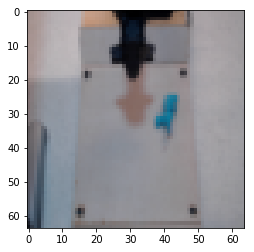

In [6]:
imshow(images[0].transpose(1, 2, 0))

In [9]:
classifier = ConcatCNN(**variant['cnn_params'])
classifier = classifier.to(ptu.device)

In [8]:
import torch.nn as nn
import torch.nn.functional as F
class TutorialNet(nn.Module):
    # https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    def __init__(self):
        super().__init__()
        self.fc_input_size = 16 * 13 * 13
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(self.fc_input_size, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, self.fc_input_size)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
classifier = TutorialNet()
classifier.to(ptu.device)

TutorialNet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=2704, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=1, bias=True)
)

In [23]:
ERROR_THRESH = 0.015
NUM_EPOCHS = 200
BATCH_SIZE = 128
TRAIN_SPLIT = 0.9
POSITIVE_CLASS_SPLIT = 0.5
NUM_TRAINING = 400

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(classifier.parameters(), lr=1e-4)

num_updates_per_epoch = int(images.shape[0]/BATCH_SIZE)
eval_frequency = 1

In [26]:
positive_training_images = positive_images[:int(TRAIN_SPLIT * positive_images.shape[0])].reshape(-1, flat_size)
negative_training_images = negative_images[:int(TRAIN_SPLIT * negative_images.shape[0])].reshape(-1, flat_size)
positive_test_images = positive_images[int(TRAIN_SPLIT * positive_images.shape[0]):].reshape(-1, flat_size)
negative_test_images = negative_images[int(TRAIN_SPLIT * negative_images.shape[0]):].reshape(-1, flat_size)

positive_training_images = positive_training_images[np.random.randint(\
        positive_training_images.shape[0], size=NUM_TRAINING // 2)]
negative_training_images = negative_training_images[np.random.randint(\
        negative_training_images.shape[0], size=NUM_TRAINING // 2)]


test_images = np.concatenate((positive_test_images, negative_test_images))
positive_test_labels = np.ones((positive_test_images.shape[0], 1))
negative_test_labels = np.zeros((negative_test_images.shape[0], 1))
test_labels = np.concatenate((positive_test_labels, negative_test_labels))
print(len(test_labels))
test_images_tensor = ptu.from_numpy(test_images)

def get_batch(positive_training_images, negative_training_images):
    positive_batch_size = int(BATCH_SIZE * POSITIVE_CLASS_SPLIT)
    negative_batch_size = BATCH_SIZE - positive_batch_size

    positive_indices = np.random.randint(positive_training_images.shape[0], size=positive_batch_size)
    negative_indices = np.random.randint(negative_training_images.shape[0], size=negative_batch_size)
    
    positive_batch_images = positive_training_images[positive_indices]
    negative_batch_images = negative_training_images[negative_indices]
    positive_batch_labels = np.ones((positive_batch_size, 1))
    negative_batch_labels = np.zeros((negative_batch_size, 1))
    
    
    images = ptu.from_numpy(np.concatenate((positive_batch_images, negative_batch_images)))
    labels = ptu.from_numpy(np.concatenate((positive_batch_labels, negative_batch_labels)))
    #labels = labels.type(torch.LongTensor)
    return images, labels

3067


RuntimeError: CUDA out of memory. Tried to allocate 144.00 MiB (GPU 0; 10.92 GiB total capacity; 6.67 GiB already allocated; 3.50 MiB free; 628.84 MiB cached)

In [27]:
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    running_loss = 0.0
    classifier.train()
    for i in range(num_updates_per_epoch):
        inputs, labels = get_batch(positive_training_images, negative_training_images)

        optimizer.zero_grad()

        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()

    # print('training loss: {}'.format(running_loss))
    # if epoch % eval_frequency == 0:
    classifier.eval()
    test_predictions = torch.round(torch.sigmoid(classifier(test_images_tensor)))
    test_predictions_np = ptu.get_numpy(test_predictions).astype(np.int)

    # import IPython; IPython.embed()
    error = np.linalg.norm(test_predictions_np - test_labels, axis=1)
    error_mean = error.mean()
    print('Epoch {}: {}'.format(epoch, error_mean))
    # test_loss = get_numpy(criterion(test_predictions, test_labels_tensor))

print('epoch {} test set error: {}'.format(epoch, error_mean))
print('num erroneous: {} out of {}'.format(np.sum(error > ERROR_THRESH),
                                                   len(test_labels)))

RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.92 GiB total capacity; 6.77 GiB already allocated; 3.50 MiB free; 535.78 MiB cached)

In [28]:
imshow(negative_training_images[200].reshape(3, 64, 64).transpose(1, 2, 0))

IndexError: index 200 is out of bounds for axis 0 with size 200

In [248]:
print(torch.round(torch.sigmoid(classifier(ptu.from_numpy(negative_training_images[50][None])))))

tensor([[0.]], device='cuda:0', grad_fn=<RoundBackward>)


In [249]:
print(torch.round(torch.sigmoid(classifier(ptu.from_numpy(positive_training_images[50][None])))))

tensor([[1.]], device='cuda:0', grad_fn=<RoundBackward>)


In [16]:
positive_test_images_tensor = ptu.from_numpy(positive_test_images)
positive_test_predictions = torch.round(torch.sigmoid(classifier(positive_test_images_tensor)))
positive_test_predictions_np = ptu.get_numpy(positive_test_predictions).astype(np.int)

# import IPython; IPython.embed()
true_positives = np.sum(positive_test_predictions_np)
positives = len(positive_test_labels)

In [17]:
negative_test_images_tensor = ptu.from_numpy(negative_test_images)
negative_test_predictions = torch.round(torch.sigmoid(classifier(negative_test_images_tensor)))
negative_test_predictions_np = ptu.get_numpy(negative_test_predictions).astype(np.int)

# import IPython; IPython.embed()
false_negatives = np.sum(negative_test_predictions_np)
negatives = len(negative_test_labels)

In [19]:
print('Precision: ', true_positives / (true_positives + false_negatives))
print('Recall: ', true_positives / positives)
print(positives + negatives)

Precision:  0.8320512820512821
Recall:  0.9833333333333333
3067


In [255]:
torch.save(classifier, 'reward_classifier.pth')

/home/jonathan/anaconda3/envs/railrl-env/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ConcatCNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jonathan/anaconda3/envs/railrl-env/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ReLU. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jonathan/anaconda3/envs/railrl-env/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type ModuleList. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/jonathan/anaconda3/envs/railrl-env/lib/python3.6/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't 